In [2]:
import random
import numpy as np
import json
from tqdm import tqdm
from datasets import Dataset

import torch

torch.manual_seed(42)

from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig, LlamaModel
import torch
from torch import compile
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import transformers
from tqdm import tqdm
import pandas as pd
import yaml
import contextlib
import os
import time
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload 2

from transformers import PreTrainedTokenizerFast, AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v0.1")
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v0.1")
tokenizer.pad_token = tokenizer.eos_token

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

import random
import numpy as np
import json
from tqdm import tqdm
from datasets import Dataset

def generate_ravel_dataset(n_samples, split="train", domains=["city"], domain_excluded_attributes=[["Latitude", "Longitude", "Timezone"]], filtering_dict_paths=[None],  seed=42):
            
    # Seed
    random.seed(seed)
    np.random.seed(seed)
    dataset = []
    
    sample_per_domain = n_samples // len(domains)
    
    for domain, excluded_attributes, filtering_dict_path in zip(domains, domain_excluded_attributes, filtering_dict_paths):
                        
        templates = {
            "Language": ["People in %s usually speak"],
            "Country": ["%s is in the country of"],
            "Continent": ["%s is in the continent of"]
        }
        
        prompt_idxs_dict = {
            "Language": [3],
            "Country": [5],
            "Continent": [3]
        }
        
        entities = json.load(open(os.path.join("./data/ravel/", f"ravel_{domain}_entity_attributes.json"), "r"))
        entities_split = json.load(open(os.path.join("./data/ravel/", f"ravel_{domain}_entity_to_split.json"), "r"))
        
        all_attributes = [a for a in list(templates.keys()) if a not in excluded_attributes]

        entities_train = {k: v for k, v in entities.items() if entities_split[k] == "train"}
        name_train = list(entities_train.keys())

        entities_test = {k: v for k, v in entities.items() if entities_split[k] != "train"}
        name_test = list(entities_test.keys())
        
        if split == "train":
            entity_dict, entity_name = entities_train, name_train
        elif split == "test":
            entity_dict, entity_name = entities_test, name_test
        else:
            raise ValueError("split must be 'train' or 'test'")
        
        if filtering_dict_path is not None:
            filtering_dict = json.load(open(filtering_dict_path, "r"))
            filtered_key = []
            
            for entity in filtering_dict.keys():
                model_knows = True
                
                entity_token_len = len(tokenizer(entity)["input_ids"])
                
                for attribute in all_attributes:                    
                    split_template_idx = [list(filtering_dict[entity][attribute].values())[i] for i in prompt_idxs_dict[attribute]]
                    if True not in split_template_idx:
                        model_knows = False
                        break
                if not model_knows:
                    filtered_key.append(entity)
            print(f"Filtering out {len(filtered_key)} out of {len(filtering_dict)} entities that the model does not know!")
            filtering_dict = {k: v for k, v in filtering_dict.items() if k not in filtered_key}
        else:
            filtering_dict = None
        
        for _ in tqdm(range(sample_per_domain)):
            
            data = {}
            
            if filtering_dict is None:
                source_entity, base_entity = random.sample(entity_name, 2)
                attribute = random.choice(all_attributes)
                another_attribute = random.choice(all_attributes)
                source_entity_dict, base_entity_dict = entity_dict[source_entity], entity_dict[base_entity]
                source_template, base_template = random.choice(templates[another_attribute]), random.choice(templates[attribute])
            else:
                source_entity, base_entity = random.sample([k for k in entity_name if k in filtering_dict.keys()], 2)
                attribute = random.choice(all_attributes)
                another_attribute = random.choice(all_attributes)
                source_entity_dict, base_entity_dict = entity_dict[source_entity], entity_dict[base_entity]
                source_template, base_template = random.choice(templates[another_attribute]), random.choice(templates[attribute])
                
            data["input_text"] = base_template % base_entity
            data["counterfactual_input_text"] = source_template % source_entity
            data["edit_instruction"] = f"{base_entity} ; {source_entity} - {attribute}"
            data["target"] = base_entity_dict[attribute]
            data["counterfactual_target"] = source_entity_dict[attribute]            
                
            dataset.append(data)
                
    dataset = Dataset.from_list(dataset)
    return dataset

city_train_set = generate_ravel_dataset(1000, split="train", filtering_dict_paths=["./notebooks/ravel_llama-3-8b_city_prompt_to_output_statistics.json"])
city_test_set =  generate_ravel_dataset(100, split="test", filtering_dict_paths=["./notebooks/ravel_llama-3-8b_city_prompt_to_output_statistics.json"])


def ravel_collate_fn(batch):
    
    def tokenize_text_inputs(texts, counterfactual_texts, target_texts):
        
        input_texts = [text + " " + target for text, target in zip(texts, target_texts)]
        input_texts = [text.replace(" \" ", " \" ") for text in input_texts]
        
        tokenized = tokenizer(input_texts, return_tensors="pt", padding=True, max_length=50, truncation=True)
        tokenized_counterfactual = tokenizer(counterfactual_texts, return_tensors="pt", padding=True, max_length=50, truncation=True)
        tokenized_labels = []
        
        for input_ids, input_text in zip(tokenized["input_ids"], texts):
            input_length = tokenizer(input_text, return_tensors="pt", padding=False)["input_ids"].shape[-1]
            label = torch.full_like(input_ids, -100)
            label[input_length:] = input_ids[input_length:]
            label[input_ids == tokenizer.pad_token_id] = -100
            tokenized_labels.append(label)
        
        tokenized_labels = torch.stack(tokenized_labels)
        return {
            "base_input_ids": tokenized["input_ids"],
            "base_attention_mask": tokenized["attention_mask"],
            "source_input_ids": tokenized_counterfactual["input_ids"],
            "source_attention_mask": tokenized_counterfactual["attention_mask"],
            "labels": tokenized_labels
        }
        
    prompts, edit_instructions, targets, counterfactual_prompts = [], [], [], []
    for b in batch:
        prompts.append(b["input_text"])
        edit_instructions.append(b["edit_instruction"])
        targets.append(b["counterfactual_target"])
        counterfactual_prompts.append(b["counterfactual_input_text"])
        
    editor_input_ids = tokenizer(edit_instructions, return_tensors="pt", padding=True, truncation=True)["input_ids"]
    
    returned_dict = {
        "editor_input_ids": editor_input_ids,
        **tokenize_text_inputs(prompts, counterfactual_prompts, targets),
    }    
    
    return returned_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Filtering out 3 out of 3552 entities that the model does not know!


100%|██████████| 1000/1000 [00:00<00:00, 4752.25it/s]


Filtering out 3 out of 3552 entities that the model does not know!


100%|██████████| 100/100 [00:00<00:00, 4753.24it/s]


In [3]:
# @torch.compile #Apparently this fails when used inside jupyter notebooks but is fine if i make dedicated scripts
from models.llama3.model import LlamaInterpretor, LlamaInterpretorConfig
from models.utils import InterpretorModelOutput
import wandb


class RavelInterpretorHypernetwork(nn.Module):
    # Separating the editor config file, from its base model's configurations
    def __init__(
        self,
        model_name_or_path="/work/frink/models/llama3-8B-HF",
        num_editing_heads=32,
        chop_editor_at_layer=8,
        intervention_layer=0,
        torch_dtype=torch.bfloat16
    ):
        super().__init__()

        self.editor_config = LlamaInterpretorConfig.from_pretrained(model_name_or_path)
        self.editor_config.name_or_path = model_name_or_path
        self.editor_config.torch_dtype = torch_dtype
        self.editor_config.num_editing_heads = num_editing_heads
        self.editor_config.chop_editor_at_layer = chop_editor_at_layer
        self.editor_config.default_intervention_layer = intervention_layer
        self.editor_config._attn_implementation = 'eager'
                
        self.editor_inner = LlamaInterpretor(self.editor_config)
        self.tokenizer = tokenizer

        self.residual_cache = None
        self.opt = None
        self.training_loss = None
        
    def forward(
        self,
        editor_input_ids: torch.Tensor = None,
        base_input_ids: torch.Tensor = None,
        base_attention_mask: torch.Tensor = None,
        source_input_ids: torch.Tensor = None,
        source_attention_mask: torch.Tensor = None,
        labels: torch.Tensor = None,
    ):
        _pred: InterpretorModelOutput = self.editor_inner(
            editor_input_ids=editor_input_ids,
            editor_attention_mask=editor_input_ids != self.editor_config.eos_token_id,
            base_input_ids=base_input_ids,
            base_attention_mask=base_attention_mask,
            source_input_ids=source_input_ids,
            source_attention_mask=source_attention_mask,
            # output_target_hidden_states=True,
        )
        
        if labels is None:
            return {
                "logits": _pred.logits,
                "intervention_weight": _pred.intervention_weights,
                "target_hidden_states": _pred.target_hidden_states,
            }
        else:
            log_prob_predictions = torch.nn.functional.log_softmax(
                _pred.logits.reshape(-1, _pred.logits.shape[-1]),
                dim=1,
            )
            
            labels = labels.reshape(-1)
            assert labels.shape == log_prob_predictions.shape[:-1]
            
            # Only consider the tokens that are not -100 in target_labels
            label_indices = labels != -100
            
            log_prob_predictions = log_prob_predictions[label_indices, :]
            labels = labels[label_indices]
            
            # Compute the cross-entropy loss with masking
            criterion = torch.nn.CrossEntropyLoss(reduction="mean")
            loss = criterion(log_prob_predictions, labels.long())
            
            return {
                "logits": _pred.logits,
                "target_hidden_states": _pred.target_hidden_states,
                "intervention_weight": _pred.intervention_weight,
                "loss": loss,
            }
        
    
    # Generate text using the target model, with a new edit application at every step.
    # This is a very slow way to generate text.
    # If you only want to edit first k tokens, use the forward pass instead with stop_editing_index = k
    def inspect_batch_prediction_ouptuts(self, batch):
        self.editor_inner.eval()
        
        with torch.no_grad():
            
            predictions = self.forward(
                editor_input_ids=batch["editor_input_ids"].to("cuda"),
                base_input_ids=batch["base_input_ids"].to("cuda"),
                base_attention_mask=batch["base_attention_mask"].to("cuda"),
                source_input_ids=batch["source_input_ids"].to("cuda"),
                source_attention_mask=batch["source_attention_mask"].to("cuda"),
            )
            
            batch_pred_ids = torch.argmax(predictions["logits"], dim=-1)
            batch_full_output = self.tokenizer.batch_decode(batch_pred_ids, skip_special_tokens=True)
            
            batch_output = []
            correct = 0
            
            for label, pred_ids in zip(batch["labels"].to("cuda"), batch_pred_ids):
                
                output_idx = label != -100
                label = label[output_idx]
                pred_ids = pred_ids[output_idx]
                batch_output.append(
                    self.tokenizer.decode(pred_ids, skip_special_tokens=True)
                )             
                
                correct += torch.sum(label == pred_ids) == torch.numel(label)
            
        return {
            "batch_output": batch_output,
            "batch_full_output": batch_full_output,
            "batch_intervention_weight": predictions["intervention_weights"],
            "n_correct": correct,
        }
        
    def evaluate_intervention(self, editor_input_text, base_prompt, source_prompt, gen_len=1):
        self.editor_inner.eval()
        
        editor_input_ids = self.tokenizer(editor_input_text, return_tensors="pt")["input_ids"]
        source_input_ids = self.tokenizer(source_prompt, return_tensors="pt")["input_ids"]
        base_input_ids = self.tokenizer(base_prompt, return_tensors="pt")["input_ids"]
        
        with torch.no_grad():
            predictions = self.forward(
                editor_input_ids=editor_input_ids.to("cuda"),
                base_input_ids=base_input_ids.to("cuda"),
                source_input_ids=source_input_ids.to("cuda"),
            )
        
        return predictions
    
    def eval_accuracy(self, test_loader, use_unaffected=False):
        
        self.editor_inner.eval()
        test_loss = []
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                predictions = self.forward(
                    editor_input_ids=batch["editor_input_ids"].to("cuda"),
                    base_input_ids=batch["base_input_ids"].to("cuda"),
                    base_attention_mask=batch["base_attention_mask"].to("cuda"),
                    source_input_ids=batch["source_input_ids"].to("cuda"),
                    source_attention_mask=batch["source_attention_mask"].to("cuda"),
                    labels=batch["labels"].to("cuda"),
                )
                test_loss.append(predictions["loss"].item())
                
                batch_pred_ids = torch.argmax(predictions["logits"], dim=-1)
                
                if use_unaffected:
                    unaffected_prediction = self.forward(
                        editor_input_ids=batch["editor_input_ids_unaffected"].to("cuda"),
                        base_input_ids=batch["base_input_ids_unaffected"].to("cuda"),
                        base_attention_mask=batch["base_attention_mask_unaffected"].to("cuda"),
                        source_input_ids=batch["source_input_ids_unaffected".to("cuda")],
                        source_attention_mask=batch["source_attention_mask_unaffected"].to("cuda"),
                        labels=batch["labels_unaffected"].to("cuda"),
                    )
                    batch_pred_ids_unaffected = torch.argmax(unaffected_prediction["logits"], dim=-1)
                    
                    correct_unaffected = []
                    
                    for label, pred_ids in zip(batch["labels_unaffected"].to("cuda"), batch_pred_ids_unaffected):
                        output_idx = label != -100
                        label = label[output_idx]
                        pred_ids = pred_ids[output_idx]
                        correct_unaffected.append((torch.sum(label == pred_ids) == torch.numel(label)))
                    
                    correct_unaffected = torch.stack(correct_unaffected)
                    
                    test_loss[-1] += unaffected_prediction["loss"].item()
                
                for i, (label, pred_ids) in enumerate(zip(batch["labels"].to("cuda"), batch_pred_ids)):
                    output_idx = label != -100
                    label = label[output_idx]
                    pred_ids = pred_ids[output_idx]
                    
                    is_correct = (torch.sum(label == pred_ids) == torch.numel(label)).item()
                    if use_unaffected:
                        # indices of the position which value is i
                        instance_idx = torch.nonzero(batch["instance_indices"].to("cuda") == i).squeeze()
                        # check if all the unaffected positions were correct
                        # if not, set is_correct to False
                        is_correct = is_correct and all(correct_unaffected[instance_idx])
                        
                    correct += is_correct
                    total += 1
                    
        return correct / total, sum(test_loss) / len(test_loss)
             

    def run_train(
        self,
        train_loader,
        test_loader=None,
        epochs=1,
        eval_per_steps: int = None,
        use_unaffected = False
    ):
        trainable_parameters = []
        for name, param in self.named_parameters():
            if "target_model" not in name:
                trainable_parameters.append(param)
                
        self.opt = optim.AdamW(trainable_parameters, lr=3e-4, weight_decay=0.01)  # usually: lr = 5e-5. 1e-3 worked well!

        for epoch in range(epochs):
            # Create a tqdm progress bar
            with tqdm(
                total=len(train_loader),
                desc=f"Epoch {epoch + 1}/{epochs}",
                unit="batch",
                disable=True,
            ) as pbar:
                num_datapoints_in_epoch = 0
                epoch_train_loss = 0
                epoch_gradient_norm = 0
                # Train loop
                batch_index = -1  # index of first batch will be 0

                for step, batch in enumerate(
                    train_loader
                ):  
                    if step % eval_per_steps == 0:
                        # Evaluate the model
                        accuracy, test_loss = self.eval_accuracy(
                            test_loader, use_unaffected=use_unaffected
                        )
                        
                        if wandb.run:
                            wandb.log(
                                {
                                    "test_average": test_loss,
                                    "test_accuracy": accuracy,
                                }
                            )
                        
                    batch_index += 1
                    self.batch = batch
                    current_batch_size = len(batch["editor_input_ids"])
                    num_datapoints_in_epoch += current_batch_size
                    self.opt.zero_grad()

                    self.prediction = self.forward(
                        editor_input_ids=batch["editor_input_ids"].to("cuda"),
                        base_input_ids=batch["base_input_ids"].to("cuda"),
                        base_attention_mask=batch["base_attention_mask"].to("cuda"),
                        source_input_ids=batch["source_input_ids"].to("cuda"),
                        source_attention_mask=batch["source_attention_mask"].to("cuda"),
                        labels=batch["labels"].to("cuda"),
                    )

                    self.prediction_loss = self.prediction["loss"]
                    
                    if use_unaffected:
                        self.prediction_loss += self.forward(
                            editor_input_ids=batch["editor_input_ids_unaffected"].to("cuda"),
                            input_ids=batch["input_ids_unaffected"].to("cuda"),
                            attention_mask=batch["attention_mask_unaffected"].to("cuda"),
                            labels=batch["labels_unaffected"].to("cuda"),
                        )["loss"]

                    # Compute the total loss and backpropagate
                    self.training_loss = self.prediction_loss
                    self.training_loss.backward()
                    nn.utils.clip_grad_norm_(
                        self.parameters(), 4.0
                    )  # just implemented this! dunno if a cap of 1 to large, so I'm messing with reducing it

                    # Check for nan gradients
                    # if check_nan_gradients(self):
                    #     break

                    # Backwards step
                    self.opt.step()

                    # metrics
                    epoch_train_loss += self.training_loss.item() * current_batch_size
                    gradients = [
                        p.grad.view(-1) for p in self.parameters() if p.grad is not None
                    ]
                    all_gradients = torch.cat(gradients)
                    gradient_norm = torch.norm(all_gradients).item()
                    epoch_gradient_norm += gradient_norm * current_batch_size

                    metrics = {
                        "step": step * (epoch + 1),
                        "train_batch_total_loss": self.training_loss.item(),
                        "train_batch_prediction_loss": self.prediction_loss.item(),
                        "train_batch_gradient_norm": gradient_norm,
                    }

                    if wandb.run:
                        wandb.log(metrics)
                    if step % 5 == 0:
                        print(metrics)

                    # Update progress bar
                    pbar.update(1)  # note: this was incorrectly displaying before!

                    # Check if it's time to save a checkpoint
                    current_time = time.time()
                    # first loop initialization
                    if batch_index == 0 and epoch == 0:
                        last_checkpoint_time = -100000

                if wandb.run:
                    wandb.log(
                        {
                            "epoch_train_total_loss": epoch_train_loss
                            / num_datapoints_in_epoch,
                            "gradient_norm": epoch_gradient_norm
                            / num_datapoints_in_epoch,
                        }
                    )
            # Save the final model
            torch.save(self.state_dict(), "final_model.pt")

In [10]:
hypernetwork = RavelInterpretorHypernetwork()
print(hypernetwork.editor_inner.hypernetwork.model.layers[3].self_attn.q_proj.weight)
hypernetwork.load_state_dict(torch.load("./final_model_layer_emb.pt"))
print(hypernetwork.editor_inner.hypernetwork.model.layers[3].self_attn.q_proj.weight)
hypernetwork = hypernetwork.to("cuda")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Parameter containing:
tensor([[ 0.0092,  0.0076,  0.0015,  ...,  0.0166,  0.0034,  0.0076],
        [ 0.0125,  0.0153,  0.0129,  ..., -0.0004,  0.0128,  0.0056],
        [ 0.0192,  0.0037, -0.0167,  ...,  0.0115,  0.0078, -0.0008],
        ...,
        [-0.0164,  0.0254,  0.0026,  ...,  0.0089, -0.0062,  0.0029],
        [-0.0457,  0.0171, -0.0064,  ..., -0.0184, -0.0020, -0.0018],
        [-0.0135, -0.0003, -0.0234,  ..., -0.0082,  0.0088,  0.0267]],
       dtype=torch.bfloat16, requires_grad=True)
Parameter containing:
tensor([[ 0.0089,  0.0075,  0.0025,  ...,  0.0161,  0.0038,  0.0064],
        [ 0.0140,  0.0150,  0.0132,  ..., -0.0007,  0.0125,  0.0052],
        [ 0.0189,  0.0035, -0.0170,  ...,  0.0108,  0.0079, -0.0018],
        ...,
        [-0.0225,  0.0284, -0.0126,  ...,  0.0140, -0.0125,  0.0140],
        [-0.0442,  0.0164,  0.0121,  ..., -0.0255, -0.0031, -0.0123],
        [-0.0072, -0.0061, -0.0176,  ..., -0.0142,  0.0138,  0.0214]],
       dtype=torch.bfloat16, requires_g

In [14]:
hypernetwork.eval_accuracy(test_loader=test_data_loader)

AttributeError: 'InterpretorModelOutput' object has no attribute 'intervention_weight'

distance


Text(158.22222222222223, 0.5, 'Source Sentence Tokens')

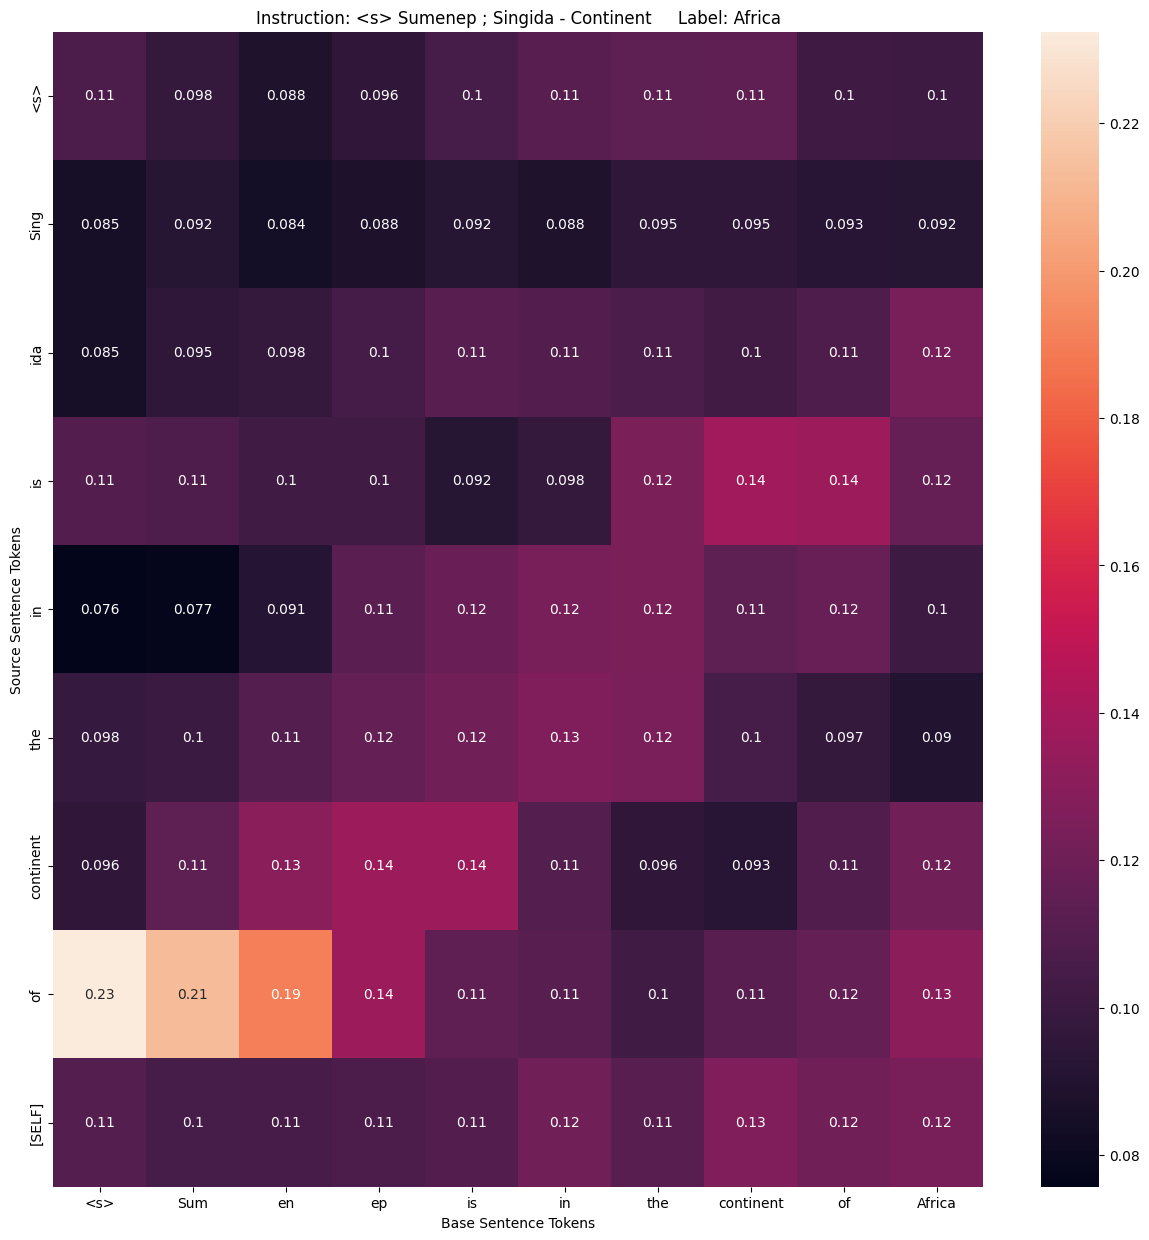

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

batch_id = 48
example_id = 0

batch_size = 2  # 50 or so
data_loader = DataLoader(
    city_train_set, batch_size=batch_size, collate_fn=ravel_collate_fn, shuffle=True
)  # batch_size, collate_fn=collate_fn)
test_data_loader = DataLoader(
    city_test_set, batch_size=batch_size, collate_fn=ravel_collate_fn, shuffle=True
)

for i, batch in enumerate(data_loader):
    if i == batch_id:
        break
    
results = hypernetwork.inspect_batch_prediction_ouptuts(batch)

editor_input_ids = batch["editor_input_ids"][example_id]
base_input_ids = batch["base_input_ids"][example_id]
source_input_ids = batch["source_input_ids"][example_id]
intervention_weight = results["batch_intervention_weight"][example_id]
label = batch["labels"][example_id]

assert intervention_weight.size() == (len(source_input_ids) + 1, len(base_input_ids))

source_axis = [tokenizer.decode([i]) for i in source_input_ids] + ["[SELF]"]
base_axis = [tokenizer.decode([i]) for i in base_input_ids]
editor_text = tokenizer.decode(editor_input_ids)
label = label[label != -100]
label = tokenizer.decode(label)

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(intervention_weight.float().cpu().numpy(), xticklabels=base_axis, yticklabels=source_axis, ax=ax, annot=True)

print(results["batch_output"][example_id])
ax.set_title(f"Instruction: {editor_text}     Label: {label}")
ax.set_xlabel("Base Sentence Tokens")
ax.set_ylabel("Source Sentence Tokens")

In [7]:
results

{'batch_output': ['distance distance', ''],
 'batch_full_output': ['distance distance distance distance distance distance distance distance',
  'distance'],
 'batch_intervention_weight': tensor([[[0.0972, 0.0771, 0.0869, 0.0786, 0.0903, 0.1260, 0.1133, 0.1104,
           0.1099, 0.1035, 0.1001],
          [0.0786, 0.1045, 0.1050, 0.0762, 0.0830, 0.0854, 0.0791, 0.1162,
           0.1187, 0.1245, 0.1177],
          [0.1230, 0.0957, 0.1309, 0.1128, 0.1123, 0.0786, 0.0747, 0.1211,
           0.1157, 0.1089, 0.1157],
          [0.1113, 0.1050, 0.1406, 0.1787, 0.1621, 0.1138, 0.0962, 0.1074,
           0.1074, 0.1289, 0.1592],
          [0.1084, 0.2305, 0.1270, 0.1270, 0.1084, 0.1099, 0.1245, 0.1006,
           0.1006, 0.1201, 0.1289],
          [0.1426, 0.1465, 0.0903, 0.0659, 0.0596, 0.0830, 0.1328, 0.1138,
           0.1138, 0.1060, 0.0923],
          [0.1079, 0.0732, 0.0996, 0.1221, 0.1152, 0.1436, 0.1465, 0.1128,
           0.1182, 0.1060, 0.0786],
          [0.1328, 0.0781, 0.1162, 0.